# Projektarbeit:

---

## Erkennen von Malariainfektionen mittels Support Vector Machines

<img src="./malaria.jpg" alt="Alt-Text" title="" style="width:800px;height:400px;"/>

<b>Die Malaria ist mit etwa 200 Millionen Erkrankten pro Jahr die häufigste Infektionskrankheit der Welt.</b>

Während Malaria weltweit noch immer zu den weitverbreitesten Erkrankungen mit hoher
Sterblichkeit zählt, fehlen im Gesundheitswesen in Regionen mit geringer Prävalenz,
z.B. in Deutschland, oft Kenntnisse und Erfahrungswerte in der Diagonistik. Malaria
wird durch den einen einzelligen Organismus, den Plasmodium-Parasiten verursacht,
der im Zuge seines Fortpflanzungszyklus menschliche Zellen befällt. Malaria kann durch
Untersuchung von Blutproben der PatientInnen unter dem Lichtmikroskop diagnostiziert
werden, bei dem der Probe ein Färbemittel hinzugefügt wird, sodass der Parasit sichtbar
wird.

In dieser Projektarbeit soll ein Algorithmus trainiert werden, der anhand der Mikroskopbilder vorhersagt, ob eine Malariainfektion vorliegt oder nicht. Dafür wird wie folgt vorgegangen:<br>

1) Datenexploration: Analyse des Datensatzes <br>
2) Datenrepräsentation: Einfache Bildvearbeitung und -aufbereitung für das Training <br>
3) Auswahl und Training Algorithmus: Baselining, Datenverarbeitung, Modellvergleich, Hyerparametertunig <br>
4) Evaluation: Kreuzvalidierung, Gütemaße und Confusionmatrix <br>
5) <i>Bonus: Vergleich mit Random Forest und Convolutional Neuronal Network</i>

In [1]:
# Bibliotheken importieren
import numpy as np
import PIL
from PIL import Image, ImageOps, ImageEnhance
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import loguniform
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

## 1. Datenexploration

---
### Fragen zum Datensatz
- Wie viele Bilder gibt es?
- Dateiformat?
- welche Auflösungen gibt es?
- Welchen Farbraum haben die Bilder?
- Welche Klassen gibt es?
    - Verteilung der Labels



### Erste Erkenntnisse
- Es gibt insgesamt 27.558 Bilder im PNG-Format.
- 13.779 Zellaufnahmen von Malariainfektionen (Klasse: positiv)
- 13.779 Zellaufnahmen ohne Infektion (Klasse: negativ)
- Klassenverteilung 1:1
- Der Farbraum ist RGB

In [2]:
#Bilder importieren für ersten Überblick
#Aus Gründen der Rechenlaufzeit und Speicherplatzebedarf werden zunächst nur 1.000 Teildaten geladen

temp_images = [] #Als PIL Image
labels = []
imgs = [] #Als np.array

# Bilder mit Label 'parasitized' importieren
filelist = glob.glob('Parasitized/*.png')
for idx, i in enumerate(filelist):
    temp_images.append(Image.open(i))
    labels.append(1)
    imgs.append(np.asarray(Image.open(i)))
    if idx == 1000:
        break
        
# Bilder mit Label 'uninfected' importieren
filelist = glob.glob('Uninfected/*.png')
for idx, i in enumerate(filelist):
    temp_images.append(Image.open(i))
    labels.append(0)
    imgs.append(np.asarray(Image.open(i)))
    if idx == 1000:
        break

# In Numpyarray konvertieren        
imgs = np.array(imgs)
lbls = np.asarray(labels)

#Check on selbe Anzahl
print(imgs.shape)
print(lbls.shape)

(2002,)
(2002,)


<ipython-input-2-9113559b90a8>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  imgs = np.array(imgs)


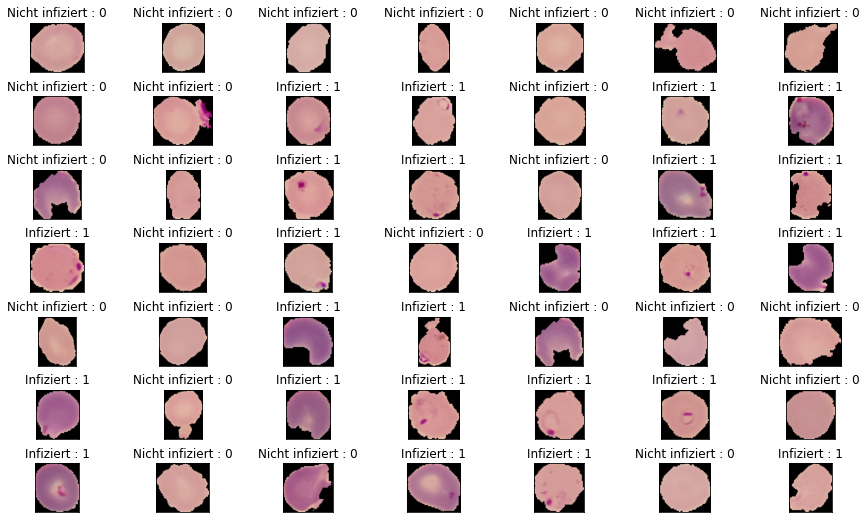

In [6]:
#Preview der Bilder laden
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint(0 , imgs.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(imgs[r[0]])
    plt.title('{} : {}'.format('Infiziert' if lbls[r[0]] == 1 else 'Nicht infiziert' ,
                               lbls[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

In [4]:
# Auflösung der einzelnen Bilder ausgeben
res = []
for i in imgs:
    res.append(i.shape)
res = np.array(res)

0.5193370165745856
2.1443298969072164


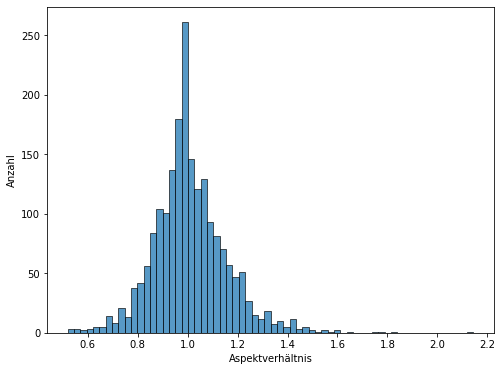

In [121]:
# Aspect Ratio berechnen und Verteilung aufzeigen
ratio = res[:,0]/res[:,1]
print(ratio.min())
print(ratio.max())
plt.figure(figsize=(8, 6))
histplt = sns.histplot(ratio)
histplt.set(xlabel='Aspektverhältnis', ylabel='Anzahl');

#### Erkenntnisse
- Aspektverhältnisse sind Normalverteil um 1
- Aber es gibt unterschiedliche Aspektverhältnisse, deshalb untersuchen ob Padding einen Einfluss hat

Min Auflösung: [46 58  3]
Max Auflösung: [235 238   3]


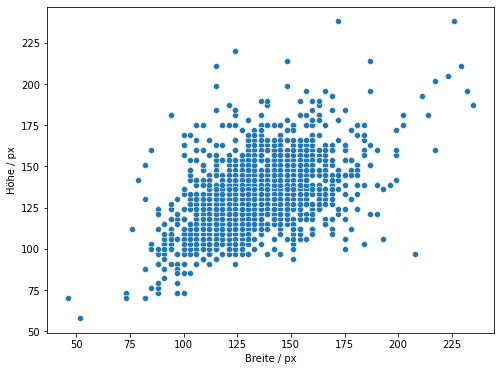

In [116]:
# Minimale und maximale Skalierung anzeigen, Histogramm der Skalierungen plotten
print(f"Min Auflösung: {res.min(axis=0)}")
print(f"Max Auflösung: {res.max(axis=0)}")
plt.figure(figsize=(8, 6))
scatplt = sns.scatterplot(x=res[:,0], y=res[:,1])
scatplt.set(xlabel='Breite / px', ylabel='Höhe / px');

#### Erkenntnisse
- Bilder liegen in verschiedenen Auflösungen vor
- Meisten Bilder 100 - 175 sowohl für Breit als auch Höhe
- Es gibt Ausreißer nach oben und unten
- Deshalb Versuch Bilder herunter zu skalieren auf niedrigsten Wert

In [7]:
# Welche Bildtiefe haben die einzelnen Bilder?
imgs[1].dtype

dtype('uint8')

#### Erkenntnisse
Bilder haben RGB Farbraum mit Pixeltiefe uint8 (Werte zwischen (0 - 255)<br>
    - Reicht Graustufen Darstellung aus?

## 2. Datenrepräsentation
- Skalieren der Auflösung
    - mit und ohne Padding
- Graustufen vs. Farben
- Kontrast erhöhen

In [8]:
#Hilfsfunktion zum Padding
def pad_img(img, size):
    width, height = img.size
    aspect_old = img.size[0] / img.size[1]
    aspect_new = size[0] / size[1]
    aspect_factor = aspect_new / aspect_old
    #Zu kleine Unterschiede in den Aspektverhältnissen nicht zulassen
    if (aspect_factor > 0.95) & (aspect_factor < 1.05):
        return img
    elif aspect_factor < 1:
        result = Image.new(img.mode, (width, int(width // aspect_factor)), 0)
        result.paste(img, (0, ((result.size[1] - img.size[1]) // 2)))
        return result
    else:
        result = Image.new(img.mode, (int(height * aspect_factor), height), 0)
        result.paste(img, ((((result.size[0] - img.size[0]) // 2), 0)))
        return result

#Hilfsfunktion zum Laden und Transformieren der Bilder aus einer PIL-Image-Liste
def load_images(img, size=None, grayscale=True, padding=False, contrast=1.0):
    images = []
    for image in img:
        if (padding == True) & (size != None):
            image = pad_img(image, size)
        if size != None:
            image = image.resize(size)
        if grayscale == True:
            image = ImageOps.grayscale(image)
        
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(contrast)
        images.append(np.asarray(image).flatten())
    
    return np.asarray(images)

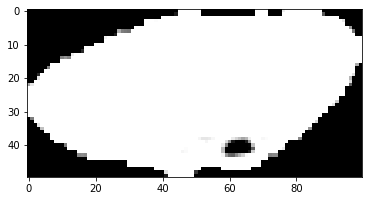

In [9]:
#Test der Funktion mit Graustufen und Kontrast
images = load_images(img=temp_images, grayscale=True, size=(100, 50), contrast=5.0)
plt.imshow(images[360,:].reshape((50, 100)), cmap='Greys_r')

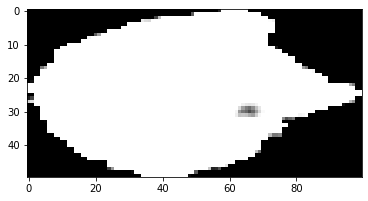

In [10]:
plt.imshow(images[123,:].reshape((50, 100)), cmap='Greys_r')

## 3. Auswahl und Training Algorithmus
---
- Modellauswahl
 - Baselining: KNN ohne Hyperparameter einstellen und Teilmenge der Daten
     - Einfluss der verschiedenen Bildeinstellungen
     - Basiswert für Problem
 - Baselining: SVM ohne Hyperparameter einstellen und Teilmenge der Daten
     - Basiswert für Problem
     - Einfluss der verschiedenen Bildeinstellungen
         - Farbe
         - Padding
         - Skalierung
     
 - Hyperparametersuche für PCA zur Reduktion der Laufzeit
 - Auswahl eines Scalers
 - Auswahl wie Bilder vorverarbeitet werden
 - Hyperparametersuche: SVM
     - GridSearch
     - RandomSearch
- Festlegen der optimalen Parameter

### Baselining - KNN
KNN ohne Hyperparameter einstellen, Bilder als Graustufen mit Größe 50x50 (50x50, da Wert in der Nähe von Bild mit minimaler Auflösung 46x58)

In [11]:
images = load_images(img=temp_images, grayscale=True, size=(50, 50))

knn_baseline = KNeighborsClassifier()

X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, stratify=labels, random_state=1234)
knn_baseline.fit(X_train, y_train)

print(f"Train Score:\t{knn_baseline.score(X_train, y_train)}")
print(f"Test Score:\t{knn_baseline.score(X_test, y_test)}")

Train Score:	0.6801998750780762
Test Score:	0.6184538653366584


Skalierung auf 130x130

In [12]:
#Bilder auf 130, 130 runterskalieren und nur Graustufen nehmen
images = load_images(img=temp_images, grayscale=True, size=(130, 130))
knn_baseline = KNeighborsClassifier()

X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, stratify=labels, random_state=1234)
knn_baseline.fit(X_train, y_train)

print(f"Train Score:\t{knn_baseline.score(X_train, y_train)}")
print(f"Test Score:\t{knn_baseline.score(X_test, y_test)}")

Train Score:	0.6764522173641474
Test Score:	0.6134663341645885


#### Erkenntnisse:
- Eine höhere Auflösung nicht die Genauigkeit
- Laufzeit erhöht sich massiv

KNN ohne Hyperparameter Einstellen, Bilder als RGB mit Größe 50x50

In [13]:
images = load_images(img=temp_images, grayscale=False, size=(50, 50))

knn_baseline = KNeighborsClassifier()

X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, stratify=labels, random_state=1234)
knn_baseline.fit(X_train, y_train)

print(f"Train Score:\t{knn_baseline.score(X_train, y_train)}")
print(f"Test Score:\t{knn_baseline.score(X_test, y_test)}")

Train Score:	0.7114303560274828
Test Score:	0.6109725685785536


#### Erkenntnisse
- RGB erhöhen nicht die Genauigkeit
- Verlängern die Laufzeit

### Baselining - SVM
Als Baselinemodell

In [14]:
images = load_images(img=temp_images, grayscale=True, size=(50, 50))
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, stratify=labels, random_state=1234)

svm_baseline = SVC(kernel='rbf')
svm_baseline.fit(X_train, y_train)

print(f"Train Score:\t{svm_baseline.score(X_train, y_train)}")
print(f"Test Score:\t{svm_baseline.score(X_test, y_test)}")

Train Score:	0.7795128044971893
Test Score:	0.6633416458852868


#### Erkenntnisse
Das Baseline SVM Modell zeigt Overfitting --> Regularisierung

SVM mit RGB

In [15]:
images = load_images(img=temp_images, grayscale=False, size=(50, 50))
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, stratify=labels, random_state=1234)

svm_baseline = SVC(kernel='rbf')
svm_baseline.fit(X_train, y_train)

print(f"Train Score:\t{svm_baseline.score(X_train, y_train)}")
print(f"Test Score:\t{svm_baseline.score(X_test, y_test)}")

Train Score:	0.7988757026858213
Test Score:	0.6583541147132169


#### Erkenntnisse
- RGB erhöht Genauigkeit nicht, Laufzeit erhöht sich stark
- Nur Graustufen
- Auflösung 50x50

Padding

In [26]:
images = load_images(img=temp_images, grayscale=True, size=(50, 50), padding=True)
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, stratify=labels, random_state=1234)

svm_baseline = SVC(kernel='rbf')
svm_baseline.fit(X_train, y_train)

print(f"Train Score:\t{svm_baseline.score(X_train, y_train)}")
print(f"Test Score:\t{svm_baseline.score(X_test, y_test)}")

Train Score:	0.7713928794503435
Test Score:	0.6533665835411472


#### Erkenntnisse
- Padding verbessert nicht die Genauigkeit
- Weiter arbeiten ohne

### Scaler
- Suche nach bestem Scaler

In [32]:
images = load_images(img=temp_images, grayscale=True, size=(50, 50))
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, stratify=labels, random_state=1234)

In [35]:
svm_pipeline1 = Pipeline([
    ('svc', SVC(kernel='rbf'))])

svm_pipeline2 = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('svc', SVC(kernel='rbf'))])

svm_pipeline3 = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf'))])

svm_pipelines = [svm_pipeline1, svm_pipeline2, svm_pipeline3]

for pipeline in svm_pipelines:
    pipeline.fit(X_train, y_train)
    print(pipeline)
    print(f"Train Score:\t{pipeline.score(X_train, y_train)}")
    print(f"Test Score:\t{pipeline.score(X_test, y_test)}")
    print("\n")

Pipeline(steps=[('svc', SVC())])
Train Score:	0.7795128044971893
Test Score:	0.6633416458852868


Pipeline(steps=[('scaler', MinMaxScaler()), ('svc', SVC())])
Train Score:	0.7695190505933791
Test Score:	0.655860349127182


Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])
Train Score:	0.8613366645846346
Test Score:	0.6932668329177057




- StandardScaler liefert die besten Ergebnisse

### PCA
PCA zur Reduzierung Features und Laufzeit

In [36]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svc', SVC(kernel='rbf'))])


grid_params = {
    'pca__n_components' : [750, 500, 250, 100, 75, 50, 25, 10, 2]
}


pipeline_pca_tuning = GridSearchCV(svm_pipeline, param_grid=grid_params, cv=5, n_jobs=-1)
pipeline_pca_tuning.fit(X_train, y_train)
print(f"Train Score:\t{pipeline_pca_tuning.score(X_train, y_train)}")
print(f"Test Score:\t{pipeline_pca_tuning.score(X_test, y_test)}")
print(pipeline_pca_tuning.best_params_)

Train Score:	0.8544659587757651
Test Score:	0.6932668329177057
{'pca__n_components': 500}




In [39]:
print(pipeline_pca_tuning.cv_results_["params"])
print(pipeline_pca_tuning.cv_results_["mean_test_score"])

[{'pca__n_components': 750}, {'pca__n_components': 500}, {'pca__n_components': 250}, {'pca__n_components': 100}, {'pca__n_components': 75}, {'pca__n_components': 50}, {'pca__n_components': 25}, {'pca__n_components': 10}, {'pca__n_components': 2}]
[0.69581776 0.70081581 0.6970697  0.68895055 0.6939447  0.69457555
 0.68395055 0.68270055 0.63647391]


#### Erkenntnisse
- 500 Features liefert beste Genauigkeit
- PCA mit 50 Features liegt nur ~0.5% darunter bei einer Feature Reduktion um Faktor 10
- Weiter arbeiten mit PCA mit n_components = 50

### Kontrast

In [40]:
contrasts = [0.25, 0.5, 1, 2.5, 5, 6, 7.5, 8, 10, 12.5]

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('svc', SVC(kernel='rbf'))])

for contrast in contrasts:
    images = load_images(img=temp_images, grayscale=True, size=(50, 50), contrast=contrast)
    X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, stratify=labels, random_state=1234)
    
    svm_pipeline.fit(X_train, y_train)
    print(f"Kontrast: {contrast}")
    print(f"Train Score:\t{svm_pipeline.score(X_train, y_train)}")
    print(f"Test Score:\t{svm_pipeline.score(X_test, y_test)}")
    print("\n")

Kontrast: 0.25
Train Score:	0.7207995003123048
Test Score:	0.6807980049875312


Kontrast: 0.5
Train Score:	0.7732667083073079
Test Score:	0.6733167082294265


Kontrast: 1
Train Score:	0.8051217988757027
Test Score:	0.683291770573566


Kontrast: 2.5
Train Score:	0.8294815740162399
Test Score:	0.685785536159601


Kontrast: 5
Train Score:	0.8419737663960025
Test Score:	0.7381546134663342


Kontrast: 6
Train Score:	0.8400999375390381
Test Score:	0.7531172069825436


Kontrast: 7.5
Train Score:	0.8475952529668956
Test Score:	0.7406483790523691


Kontrast: 8
Train Score:	0.8482198625858838
Test Score:	0.7456359102244389


Kontrast: 10
Train Score:	0.84946908182386
Test Score:	0.7556109725685786


Kontrast: 12.5
Train Score:	0.8525921299188007
Test Score:	0.7581047381546134




#### Erkenntnisse
- Mit Kontrast von 7.5 weiterrechnen
- höhre Werte liefern ähnliche Werte, aber Befürchtung, dass zuviele Features kleine Unterschiede dadurch verloren gehen

### Hyperparameter Tuning SVM GridSearch

In [41]:
#Daten zur Hyperparametersuche
images = load_images(img=temp_images, grayscale=True, size=(50, 50), contrast=7.5)
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, stratify=labels, random_state=1234)  

In [42]:
#Pipeline verwendet für Hyperparametersuche
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('svc', SVC(kernel='rbf'))])

In [43]:
C = [0.01, 0.1, 1, 10, 100, 200, 300]
gamma = [1e-10, 1e-8, 1e-4, 1, 1e1]

grid_params = {
    "svc__C" : C,
    "svc__gamma" : gamma
}

svm_pipeline_hp_tuning = GridSearchCV(svm_pipeline, param_grid=grid_params, cv=5, n_jobs=-1)
svm_pipeline_hp_tuning.fit(X_train, y_train)
    
print(f"Train Score:\t{svm_pipeline_hp_tuning.score(X_train, y_train)}")
print(f"Test Score:\t{svm_pipeline_hp_tuning.score(X_test, y_test)}")
print(svm_pipeline_hp_tuning.best_params_)

Train Score:	0.94316052467208
Test Score:	0.7780548628428927
{'svc__C': 300, 'svc__gamma': 0.0001}


Eingrenzen von C

In [45]:
C = np.linspace(150, 450, 20)
gamma = [1e-10, 1e-8, 1e-4, 1, 1e1]

grid_params = {
    "svc__C" : C,
    "svc__gamma" : gamma
}

svm_pipeline_hp_tuning = GridSearchCV(svm_pipeline, param_grid=grid_params, cv=5, n_jobs=-1)
svm_pipeline_hp_tuning.fit(X_train, y_train)
    
print(f"Train Score:\t{svm_pipeline_hp_tuning.score(X_train, y_train)}")
print(f"Test Score:\t{svm_pipeline_hp_tuning.score(X_test, y_test)}")
print(svm_pipeline_hp_tuning.best_params_)

Train Score:	0.948157401623985
Test Score:	0.7755610972568578
{'svc__C': 386.8421052631579, 'svc__gamma': 0.0001}


Eingrenzen von Gamma

In [49]:
C = np.linspace(250, 450, 20)
gamma = [0.5e-4, 0.75e-4, 1e-4, 1.125e-4, 1.25e-4, 1.375e-4, 1.5e-4]


grid_params = {
    "svc__C" : C,
    "svc__gamma" : gamma
}

svm_pipeline_hp_tuning = GridSearchCV(svm_pipeline, param_grid=grid_params, cv=5, n_jobs=-1)
svm_pipeline_hp_tuning.fit(X_train, y_train)
    
print(f"Train Score:\t{svm_pipeline_hp_tuning.score(X_train, y_train)}")
print(f"Test Score:\t{svm_pipeline_hp_tuning.score(X_test, y_test)}")
print(svm_pipeline_hp_tuning.best_params_)

Train Score:	0.9643972517176764
Test Score:	0.7880299251870324
{'svc__C': 376.3157894736842, 'svc__gamma': 0.00015}


Versuch mit gamma = 'scale' (default) zur Reduzierung der Laufzeit

In [47]:
C = np.linspace(250, 450, 20)

grid_params = {
    "svc__C" : C
}

svm_pipeline_hp_tuning = GridSearchCV(svm_pipeline, param_grid=grid_params, cv=5, n_jobs=-1)
svm_pipeline_hp_tuning.fit(X_train, y_train)
    
print(f"Train Score:\t{svm_pipeline_hp_tuning.score(X_train, y_train)}")
print(f"Test Score:\t{svm_pipeline_hp_tuning.score(X_test, y_test)}")
print(svm_pipeline_hp_tuning.best_params_)

Train Score:	0.9975015615240475
Test Score:	0.7630922693266833
{'svc__C': 250.0}


- Overfitting

### Hyperparameter Tuning SVM RandomSearch

In [48]:
C = loguniform(1e2, 5e2)
gamma = loguniform(1e-5, 1e-3)

param_distributions = {
    "svc__C": C,
    "svc__gamma": gamma
}

svm_pipeline_hp_tuning_rand = RandomizedSearchCV(svm_pipeline,
                                                 param_distributions=param_distributions,
                                                 cv=5,
                                                 n_iter=200,
                                                 n_jobs=-1,
                                                 verbose=2)

svm_pipeline_hp_tuning_rand.fit(X_train, y_train)

print(f"Train Score:\t{svm_pipeline_hp_tuning_rand.score(X_train, y_train)}")
print(f"Test Score:\t{svm_pipeline_hp_tuning_rand.score(X_test, y_test)}")
print(svm_pipeline_hp_tuning_rand.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.7min finished


Train Score:	0.976889444097439
Test Score:	0.7880299251870324
{'svc__C': 343.9653057506895, 'svc__gamma': 0.00020948135681866665}


#### Beste Wertekombination von C und Gamma
- Aus RandomSearch
- C = 343.96531
- gamma = 0.00020948

## 4) Evaluation

 - Laden des kompletten Datensatzes
 - Aufteilen in Trainings und Testdaten
 - Kreuzvalidierung
 - Trainieren auf Trainingsdaten und Confusion Matrix
 - Fazit
 
### Daten einlesen

In [122]:
#Hilfsfunktion zum Laden und Transformieren der Bilder
def transform_image(image, size=None, grayscale=True, padding=False, contrast=1.0):
    if (padding == True) & (size != None):
        image = pad_img(image, size)
    if size != None:
         image = image.resize(size)
    if grayscale == True:
         image = ImageOps.grayscale(image)
        
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(contrast)

    return np.asarray(image).flatten()

In [123]:
#Skalierung
size = (50, 50)
#Padding ja / nein?
padding = False
#Graustufen ja / nein?
grey=True
#Kontrast
contrast = 7.5



# Bilder mit Label 'parasitized' importieren
labels = []
imgs = []
filelist = glob.glob('Parasitized/*.png')
for idx, i in enumerate(filelist):
    tmp_image = Image.open(i)
    imgs.append(transform_image(tmp_image, size=size, grayscale=grey, padding=padding, contrast=contrast))
    tmp_image.close()
    labels.append(1)
    if(idx % 2000 == 0):
        print(f"{idx} Bilder aus Parasitized geladen")
print("\n")
        
# Bilder mit Label 'uninfected' importieren
filelist = glob.glob('Uninfected/*.png')
for idx, i in enumerate(filelist):
    tmp_image = Image.open(i)
    imgs.append(transform_image(tmp_image, size=size, grayscale=grey, padding=padding, contrast=contrast))
    tmp_image.close()
    labels.append(0)
    if(idx % 2000 == 0):
        print(f"{idx} Bilder aus Uninfected geladen")
        
y = np.asarray(labels)
X = np.asarray(imgs)

0 Bilder aus Parasitized geladen
2000 Bilder aus Parasitized geladen
4000 Bilder aus Parasitized geladen
6000 Bilder aus Parasitized geladen
8000 Bilder aus Parasitized geladen
10000 Bilder aus Parasitized geladen
12000 Bilder aus Parasitized geladen


0 Bilder aus Uninfected geladen
2000 Bilder aus Uninfected geladen
4000 Bilder aus Uninfected geladen
6000 Bilder aus Uninfected geladen
8000 Bilder aus Uninfected geladen
10000 Bilder aus Uninfected geladen
12000 Bilder aus Uninfected geladen


In [124]:
#Daten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=1234)

### Kreuzvalidierung

In [125]:
#Kreuzvalidierung

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('svc', SVC(kernel='rbf', C=343.96531, gamma=0.00020948))])

cross_val_results = cross_val_score(svm_pipeline, X=X, y=y, cv=5, n_jobs=-1, verbose=5)

print(f"Cross Val Score: {cross_val_results}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.9min remaining:  5.9min


Cross Val Score: [0.84996372 0.85141509 0.85976052 0.84993649 0.8519325 ]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished


In [126]:
print(f"Mean Cross Val Score: {cross_val_results.mean()} +- {cross_val_results.std()}")

Mean Cross Val Score: 0.8526016643319773 +- 0.00366515772922633


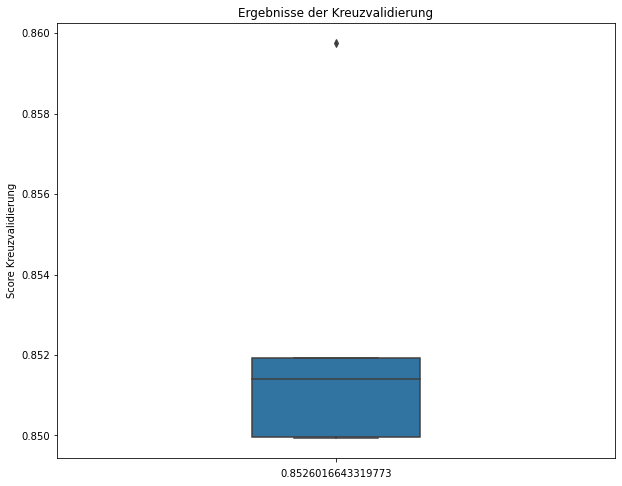

In [133]:
plt.figure(figsize=(10, 8))
boxplt = sns.boxplot(y=cross_val_results, width=0.3)
boxplt.set(title='Ergebnisse der Kreuzvalidierung',
           xlabel=cross_val_results.mean(),
          ylabel='Score Kreuzvalidierung');

#### Erkenntnisse
Das Modell zeigt eine gute Generalisierung, da die Standardabweichung der Kreuzvalidierung sehr niedrig ist.
Eine Accuracy von 85% ist allerdings als eher unzureichend für den Einsatz im medizinischen Bereich einzustufen.

### Confusion Matrix

In [128]:
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=50)),
                ('svc', SVC(C=343.96531, gamma=0.00020948))])

<Figure size 720x720 with 0 Axes>

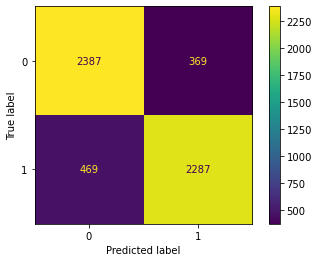

In [129]:
plt.figure(figsize=((10, 10)))
plot_confusion_matrix(svm_pipeline, X_test, y_test);

#### Erkenntnisse
- Daten liegen 50:50 verteilt vor
- Das Modell hat mehr negative (uninfected) als positive (paratisized) Vorhersagen
    - 2856 (negativ) zu 2656 (positiv) von 5512 Datenpunkten
- Die meisten Fehler liegen bei False Negatives (469)

- Für die Fragestellung der Erkennung von infizierten Zellen sind False Negatives schlimmer als False Positives

In [130]:
#Abschluss Modell auf ganzen Daten fitten
#svm_pipeline_best = svm_pipeline.fit(X, y)

## 5) Random Forest als Vergleichsmodell

In [131]:
forest_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('forest', RandomForestClassifier(n_estimators=200))])

params_grid = {'forest__max_depth' : np.linspace(10, 100, 10),
              'forest__n_estimators' : [200, 500]}

forest_hp_tuning = GridSearchCV(forest_pipeline, param_grid=params_grid, cv=5, verbose=10, n_jobs=-1)

forest_hp_tuning.fit(X_train, y_train)

print(f"Train Score:\t{forest_hp_tuning.score(X_train, y_train)}")
print(f"Test Score:\t{forest_hp_tuning.score(X_test, y_test)}")
print(forest_hp_tuning.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 23.0min remaining:   57.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 23.4min finished


Train Score:	0.9999546402975596
Test Score:	0.7922714078374455
{'forest__max_depth': 40.0, 'forest__n_estimators': 200}


- Schlechter als SVM und zeigt Overfitting